In [1]:
import pandas as pd
from astropy.units import Quantity, Unit
from astropy.cosmology import Planck15, FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from tqdm import tqdm
import os
from random import randint
from subprocess import Popen, PIPE
import pickle

import xga
xga.NUM_CORES = 40
from xga.samples import ClusterSample
from xga.imagetools.misc import physical_rad_to_pix
from xga.sourcetools.misc import rad_to_ang, nh_lookup
from xga import CENSUS, COUNTRATE_CONV_SCRIPT
from xga.relations.clusters.LT import xcs_sdss_r500_52
from xga.products.relation import ScalingRelation
from xga.sourcetools.match import simple_xmm_match

%matplotlib inline

In [2]:
cosmo = FlatLambdaCDM(70, 0.3)
cosmo

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)

In [9]:
chos_samp = pd.read_csv("poss_nustar_targets.csv")
chos_samp

,name,MCXC,LoVoCCSID,LoVoCCS_name,ra,dec,redshift,L500,M500,R500,...,old_LoVoCCSID,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,NUSTAR_R500_FRAC
0,MCXCJ2201.9-5956,J2201.9-5956,7,LoVoCCS-7,330.483333,-59.949444,0.0980,4.204419,4.5890,1.1367,...,6.0,5,A3827,330.48,-59.95,0.0980,1.0,yes,Currently using A3825 catalogs. Note the 2 clu...,0.0
1,MCXCJ0257.8+1302,J0257.8+1302,14,LoVoCCS-14,44.457500,13.049167,0.0722,3.592916,4.2452,1.1169,...,13.0,11,A399,44.46,13.05,0.0722,1.0,yes,NaN,0.0
2,MCXCJ2325.3-1207,J2325.3-1207,15,LoVoCCS-15,351.333333,-12.127222,0.0852,3.557935,4.1821,1.1066,...,14.0,12,A2597,351.33,-12.13,0.0852,1.0,yes,NaN,0.0
3,MCXCJ0052.7-8015,J0052.7-8015,19,LoVoCCS-19,13.187083,-80.266389,0.1141,3.393306,3.9812,1.0783,...,18.0,14,A2837,13.19,-80.27,0.1141,1.0,yes,NaN,0.0
4,MCXCJ2034.7-3548,J2034.7-3548,22,LoVoCCS-22,308.699583,-35.813333,0.0894,2.963013,3.7297,1.0637,...,21.0,17,A3695,308.70,-35.81,0.0894,1.0,yes,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,MCXCJ1332.9-2519,J1332.9-2519,116,LoVoCCS-116,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,...,113.0,86,RXCJ1332.9-2519,203.23,-25.32,0.1199,1.0,yes,Not very clear lensing peak,0.0
83,MCXCJ0821.0+0751,J0821.0+0751,119,LoVoCCS-119,125.257500,7.866111,0.1100,1.110969,2.0211,0.8614,...,116.0,88,RXCJ0821.0+0751,125.26,7.87,0.1100,1.0,yes,NaN,0.0
84,MCXCJ2125.2-0657,J2125.2-0657,140,LoVoCCS-140,321.301667,-6.965556,0.1153,1.018847,1.9100,0.8438,...,137.0,103,RXCJ2125.2-0657,321.30,-6.97,0.1153,NaN,partially,NaN,0.0
85,MCXCJ1416.8-1158,J1416.8-1158,144,LoVoCCS-144,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,...,141.0,106,RXCJ1416.8-1158,214.21,-11.98,0.0982,NaN,no,NaN,0.0


In [30]:
with tqdm(desc='Fetching nH', total=len(chos_samp)) as onwards:
    nhs = []
    for row_ind, row in chos_samp.iterrows():
        nh = nh_lookup(Quantity([row['ra'], row['dec']], 'deg'))[0]
        nhs.append(nh)
        onwards.update(1)
nhs = Quantity(nhs)

Fetching nH: 100%|██████████| 87/87 [00:03<00:00, 27.37it/s]


In [31]:
nhs

<Quantity [0.0277 , 0.099  , 0.0225 , 0.0551 , 0.0292 , 0.0219 , 0.0422 ,
           0.0155 , 0.0408 , 0.0399 , 0.00973, 0.0137 , 0.0291 , 0.0267 ,
           0.0231 , 0.0306 , 0.0163 , 0.0253 , 0.0516 , 0.025  , 0.0214 ,
           0.0146 , 0.0512 , 0.0508 , 0.0298 , 0.0402 , 0.0283 , 0.0108 ,
           0.0151 , 0.0366 , 0.0441 , 0.0144 , 0.0261 , 0.0181 , 0.0281 ,
           0.0138 , 0.011  , 0.0148 , 0.0482 , 0.0328 , 0.0175 , 0.0269 ,
           0.0141 , 0.0345 , 0.0268 , 0.0283 , 0.0624 , 0.0259 , 0.0464 ,
           0.0195 , 0.0108 , 0.019  , 0.0171 , 0.0195 , 0.0256 , 0.0526 ,
           0.0128 , 0.0477 , 0.0605 , 0.0367 , 0.0114 , 0.0387 , 0.0836 ,
           0.0467 , 0.0292 , 0.0192 , 0.0138 , 0.0201 , 0.0365 , 0.0296 ,
           0.105  , 0.0167 , 0.0768 , 0.0333 , 0.0672 , 0.00914, 0.0586 ,
           0.0173 , 0.0288 , 0.0284 , 0.053  , 0.0539 , 0.0519 , 0.0187 ,
           0.0666 , 0.0526 , 0.0647 ] 1e+22 / cm2>

/mnt/home/turne540/software/anaconda3/envs/test_daxa_dev/lib/python3.8/site-packages/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


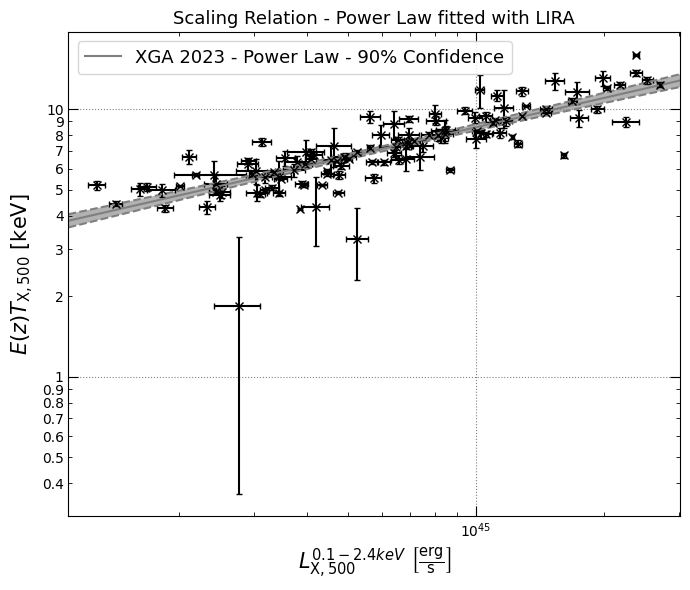

In [5]:
with open('lovisari_T500vsL_0.12.4_500_xgav0.4.xgarel', 'rb') as reado:
    t_l_rel = pickle.load(reado)
t_l_rel.view(figsize=(7, 6), grid_on=True)

In [ ]:
# samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
# samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))
# chos_samp = samp[samp['LoVoCCS_name'].isin(chosen)]
# chos_samp = chos_samp.reset_index(drop=True)
# chos_samp

In [10]:
chos_samp.shape

(87, 24)

In [11]:
ls = Quantity(chos_samp['L500'].values*1e+44, 'erg/s')
z = chos_samp['redshift'].values
pred_t = t_l_rel.predict(ls, z, cosmo)
pred_t

<Quantity [5.95852433, 5.69885055, 5.64281121, 5.46759186, 5.26858176,
           5.16860519, 5.11935533, 5.06936236, 5.19270326, 5.08639503,
           4.98192945, 4.87889646, 4.73011388, 4.68028052, 4.67723629,
           4.64148635, 4.54470487, 4.51370515, 4.4822096 , 4.41024946,
           4.43353755, 4.34838838, 4.38886998, 4.27252954, 4.29933689,
           4.36499868, 4.2599817 , 4.32520805, 4.23488492, 4.13458329,
           4.19637074, 4.12978001, 4.12041616, 4.12662015, 4.18499737,
           4.08827864, 4.04216092, 4.13739993, 4.06462207, 4.13841597,
           4.00081867, 4.03333281, 3.97092581, 3.97165039, 4.0713015 ,
           3.96870927, 3.99466325, 3.92608057, 3.84194106, 3.82489018,
           3.79752344, 3.81917498, 3.70096549, 3.68800995, 3.81802665,
           3.7405826 , 3.72453964, 3.61805306, 3.72811599, 3.68239151,
           3.70587748, 3.6712761 , 3.73862023, 3.62518397, 3.63817739,
           3.62440271, 3.68984039, 3.61482616, 3.58426657, 3.63396117,
      

In [12]:
z

array([0.098 , 0.0722, 0.0852, 0.1141, 0.0894, 0.094 , 0.098 , 0.1082,
       0.0539, 0.0846, 0.0965, 0.0957, 0.1021, 0.0852, 0.076 , 0.0834,
       0.1184, 0.1168, 0.0906, 0.1195, 0.0951, 0.1147, 0.0897, 0.1072,
       0.0824, 0.0458, 0.0943, 0.0475, 0.0894, 0.1164, 0.0768, 0.1065,
       0.111 , 0.0871, 0.0442, 0.0853, 0.1057, 0.0569, 0.0825, 0.0442,
       0.1108, 0.0817, 0.112 , 0.0963, 0.0353, 0.0765, 0.0554, 0.0851,
       0.1198, 0.094 , 0.1024, 0.0822, 0.115 , 0.1186, 0.0355, 0.0582,
       0.0624, 0.1176, 0.0544, 0.078 , 0.062 , 0.0808, 0.0397, 0.0916,
       0.075 , 0.0788, 0.03  , 0.0718, 0.072 , 0.0416, 0.097 , 0.0766,
       0.0728, 0.0786, 0.119 , 0.0564, 0.0901, 0.1084, 0.0812, 0.0822,
       0.1076, 0.0613, 0.1199, 0.11  , 0.1153, 0.0982, 0.1043])

In [13]:
ls

<Quantity [4.204419e+44, 3.592916e+44, 3.557935e+44, 3.393306e+44,
           2.963013e+44, 2.828545e+44, 2.770068e+44, 2.734146e+44,
           2.716018e+44, 2.672473e+44, 2.565193e+44, 2.419356e+44,
           2.241343e+44, 2.127767e+44, 2.097956e+44, 2.074613e+44,
           2.053481e+44, 2.010759e+44, 1.903100e+44, 1.893646e+44,
           1.858113e+44, 1.809494e+44, 1.793951e+44, 1.706366e+44,
           1.678567e+44, 1.667482e+44, 1.663138e+44, 1.629622e+44,
           1.625536e+44, 1.579007e+44, 1.558638e+44, 1.552700e+44,
           1.552593e+44, 1.509152e+44, 1.482131e+44, 1.467361e+44,
           1.462214e+44, 1.460216e+44, 1.438718e+44, 1.437223e+44,
           1.431443e+44, 1.406968e+44, 1.404549e+44, 1.375433e+44,
           1.358380e+44, 1.336537e+44, 1.323277e+44, 1.312476e+44,
           1.296543e+44, 1.236332e+44, 1.226090e+44, 1.211831e+44,
           1.162194e+44, 1.156778e+44, 1.138819e+44, 1.108636e+44,
           1.101682e+44, 1.095941e+44, 1.093054e+44, 1.090082e

In [14]:
flux = ((ls)/ (4*np.pi*(cosmo.luminosity_distance(z)**2))).to('erg/(s cm^2)')
flux

<Quantity [1.73152047e-11, 2.82420504e-11, 1.97259321e-11, 1.00908414e-11,
           1.48349615e-11, 1.27298786e-11, 1.14080672e-11, 9.11225254e-12,
           3.93110702e-11, 1.50400181e-11, 1.09173268e-11, 1.04808220e-11,
           8.45751342e-12, 1.17967830e-11, 1.48045878e-11, 1.20336053e-11,
           5.63916786e-12, 5.68605685e-12, 9.26241394e-12, 5.09761324e-12,
           8.15797352e-12, 5.32063541e-12, 8.91818030e-12, 5.80119351e-12,
           9.98784515e-12, 3.38188474e-11, 7.43439419e-12, 3.06520481e-11,
           8.13859540e-12, 4.49823931e-12, 1.07589052e-11, 5.35336520e-12,
           4.89847931e-12, 7.98521748e-12, 3.23503484e-11, 8.11517976e-12,
           5.12343784e-12, 1.88838256e-11, 8.53877574e-12, 3.13701453e-11,
           4.53376353e-12, 8.52404824e-12, 4.34687717e-12, 5.87969565e-12,
           4.70934435e-11, 9.30216444e-12, 1.80908432e-11, 7.29475062e-12,
           3.47142043e-12, 5.56411732e-12, 4.59763097e-12, 7.24778702e-12,
           3.39816934e-12

### Currently Exploring

In [17]:
sel = chos_samp['LoVoCCSID'] == 7
sel

0      True
1     False
2     False
3     False
4     False
      ...  
82    False
83    False
84    False
85    False
86    False
Name: LoVoCCSID, Length: 87, dtype: bool

In [35]:
print(nhs[sel])
print(pred_t[sel])
print(z[sel])
print('\n\n')
print(ls[sel])
print(flux[sel])


[0.0277] 1e+22 / cm2
[5.95852433] keV
[0.098]



[4.204419e+44] erg / s
[1.73152047e-11] erg / (cm2 s)


In [34]:
1.73152047e-11 / 6.3262e-10

0.027370624861686316

In [ ]:
0.00181441628

In [36]:
0.00181441628 / 0.027370624861686316

0.06629064148768626

In [ ]:
print(COUNTRATE_CONV_SCRIPT)
with open(COUNTRATE_CONV_SCRIPT, 'r') as c_script:
    script = c_script.read()

In [ ]:
# This is one of XCS' recent observations of DES clusters
DONOR_OBS = "0864080901"

# Setting up paths to files required for simulating XMM spectrum - these will be filled in with ObsID
#  and instrument when required
arf_path = "xmm_resp/{o}_{i}_exp1arf.fits"
rmf_path = "xmm_resp/{o}_{i}_exp1rmf.fits"
spec_path = "xmm_resp/{o}_{i}_exp1spec.fits"

In [ ]:
DONOR_OBS = "0880810201"

# Setting up paths to files required for simulating XMM spectrum - these will be filled in with ObsID
#  and instrument when required
arf_path = "xmm_resp/{o}_{i}_LoVoCCS-116_ra125.2575_dec7.866111111_ri0.0_ro0.09746580167775488_grpTrue_mincnt5.arf"
rmf_path = "xmm_resp/{o}_{i}_LoVoCCS-116_ra125.2575_dec7.866111111_ri0.0_ro0.09746580167775488_grpTrue_mincnt5.rmf"
spec_path = "xmm_resp/{o}_{i}_LoVoCCS-116_ra125.2575_dec7.866111111_ri0.0_ro0.09746580167775488_" \
            "grpTrue_mincnt5_spec.fits"

In [ ]:
fits.open(rmf_path.format(o=DONOR_OBS, i='pn'))[1].header['FILTER']

In [ ]:
arfs_str = " ".join([arf_path.format(o=DONOR_OBS, i='pn'), 
                     arf_path.format(o=DONOR_OBS, i='mos1'), 
                     arf_path.format(o=DONOR_OBS, i='mos2')])
arfs_str = "{" + arfs_str + "}"
rmfs_str = " ".join([rmf_path.format(o=DONOR_OBS, i='pn'), 
                     rmf_path.format(o=DONOR_OBS, i='mos1'), 
                     rmf_path.format(o=DONOR_OBS, i='mos2')])
rmfs_str = "{" + rmfs_str + "}"

obs_str = "{" + " ".join([DONOR_OBS, DONOR_OBS, DONOR_OBS]) + "}"
inst_str = "{" + " ".join(['PN', 'MOS1', 'MOS2']) + "}"

lo_lims = "{0.5 0.1 0.01}"
hi_lims = "{2.0 2.4 100.0}"

In [ ]:
# for row_ind, row in chos_samp.iterrows():
for chos in chosen:
    row = chos_samp[chos_samp['LoVoCCS_name'] == chos].iloc[0]
    row_ind = chos_samp[chos_samp['LoVoCCS_name'] == chos].index[0]
    nh = nh_lookup(Quantity([row['ra'], row['dec']], 'deg'))[0].value
    print(row['LoVoCCS_name'], nh, row['redshift'], flux[row_ind], pred_t[row_ind], 
          rad_to_ang(Quantity(row['R500'], 'Mpc'), row['redshift']))

In [ ]:
wpimm_ctr = Quantity([[4.299, 1.193, 1.193], 
                      [3.811, 1.052, 1.052], 
                      [2.118, 0.5845, 0.5845], 
                      [3.484, 0.9659, 0.9659], 
                      [1.920, 0.5303, 0.5303], 
                      [1.937, 0.5327, 0.5327], 
                      [3.653, 1.007, 1.007], 
                      [1.849, 0.5108, 0.5108], 
                      [3.295, 0.9108, 0.9108], 
                      [1.747, 0.4833, 0.4833], 
                      [1.447, 0.3994, 0.3994], 
                      [1.344, 0.3710, 0.3710], 
                      [1.311, 0.3616, 0.3616], 
                      [2.953, 0.8079, 0.8079], 
                      [1.263, 0.3508, 0.3508], 
                      [1.553, 0.4259, 0.4259]], 'ct/s')
print(wpimm_ctr)

In [ ]:
exps = []
for ind in range(len(chos_samp)):
    e = Quantity(30000, 'ct') / wpimm_ctr[ind, :].sum()
    exps.append(max(e, Quantity(7000, 's')))
#     print(e)
print(sum(exps))

In [ ]:
for chos in chosen:
    row = chos_samp[chos_samp['LoVoCCS_name'] == chos].iloc[0]
    row_ind = chos_samp[chos_samp['LoVoCCS_name'] == chos].index[0]
    nh = nh_lookup(Quantity([row['ra'], row['dec']], 'deg'))[0].value
#     print(row['other_names'], row['LoVoCCS_name'], nh, flux[row_ind].to('1e-11 erg/s/cm^2').round(3), pred_t[row_ind].round(3), 
#           rad_to_ang(Quantity(row['R500'], 'Mpc'), row['redshift']).to('arcmin').round(3), exps[row_ind].to('ks'))
    
    print(row['other_names'], row['LoVoCCS_name'], flux[row_ind].to('1e-11 erg/s/cm^2').round(3), 
          wpimm_ctr[row_ind, 0], wpimm_ctr[row_ind, 1], pred_t[row_ind].round(3), wpimm_ctr[row_ind, :].sum().round(3)
          )

In [ ]:
with tqdm(total=len(chos_samp), desc="Running Simulations") as onwards:
    for row_ind, row in chos_samp.iterrows():
        if not os.path.exists("sim_outputs/{}".format(row['LoVoCCS_name'])):
            os.makedirs("sim_outputs/{}".format(row['LoVoCCS_name']))
        
        outfile = os.getcwd()+"/sim_outputs/{}/sim.csv".format(row['LoVoCCS_name'])
        scfile = os.getcwd()+"/sim_outputs/{}/sim.xcm".format(row['LoVoCCS_name'])

        nh = nh_lookup(Quantity([row['ra'], row['dec']], 'deg'))[0].value
        temp = pred_t[row_ind].value
        par_vals = "{" + " ".join([str(nh), str(temp), '0.3', str(row['redshift']), '1']) + "}"
        
        cur_script = script.format(ab='angr', H0=cosmo.H0.value, q0=0., lamb0=cosmo.Ode0, rmf=rmfs_str, 
                                   arf=arfs_str, obs=obs_str, inst=inst_str, m="tbabs*apec", 
                                   pn="{nH kT Abundanc Redshift norm}", pv=par_vals, lll=lo_lims, 
                                   lul=hi_lims, redshift=str(row['redshift']), of=outfile, rid=randint(0, 1e+8))
        
        with open(scfile, 'w') as scripto:
            scripto.write(cur_script)
                
        out, err = Popen("xspec - " + scfile, shell=True, stdout=PIPE, stderr=PIPE).communicate()
        onwards.update(1)

In [ ]:
obs_comb_exps = []
for row_ind, row in chos_samp.iterrows():
    outfile = os.getcwd() + "/sim_outputs/{}/sim.csv".format(row['LoVoCCS_name'])
    
    mcxc_lum = ls[row_ind].value
    
    if pred_t[row_ind].value <= 1.5:
        target_cnts = 1000
    elif pred_t[row_ind].value <= 3.0 and pred_t[row_ind].value > 1.5:
        target_cnts = 1500
    elif pred_t[row_ind].value <= 5.0 and pred_t[row_ind].value > 3:
        target_cnts = 2000
    else:
        target_cnts = 2500
    target_cnts *= 15
#     target_cnts = 10000
    
#     print(target_cnts)
    
    fak_info = pd.read_csv(outfile)

#     print(fak_info)
    
    sim_lum = fak_info.loc[1, 'Lx_{}PN'.format(DONOR_OBS)] * 10**44
#     print(sim_lum)
    lum_rat = mcxc_lum / sim_lum
    
    pn_sim_cnt_rate_124 = fak_info.loc[1, 'rate_{}PN'.format(DONOR_OBS)]
    pn_sim_cnt_rate_52 = fak_info.loc[0, 'rate_{}PN'.format(DONOR_OBS)]
    pn_cr_124_to_52 = pn_sim_cnt_rate_52/pn_sim_cnt_rate_124
    
    m1_sim_cnt_rate_124 = fak_info.loc[1, 'rate_{}MOS1'.format(DONOR_OBS)]
    m1_sim_cnt_rate_52 = fak_info.loc[0, 'rate_{}MOS1'.format(DONOR_OBS)]
    m1_cr_124_to_52 = m1_sim_cnt_rate_52/m1_sim_cnt_rate_124
    
    m2_sim_cnt_rate_124 = fak_info.loc[1, 'rate_{}MOS2'.format(DONOR_OBS)]
    m2_sim_cnt_rate_52 = fak_info.loc[0, 'rate_{}MOS2'.format(DONOR_OBS)]
    m2_cr_124_to_52 = m2_sim_cnt_rate_52/m2_sim_cnt_rate_124
        
    pn_cr = fak_info.loc[1, 'rate_{}PN'.format(DONOR_OBS)] * lum_rat * pn_cr_124_to_52
    m1_cr = fak_info.loc[1, 'rate_{}MOS1'.format(DONOR_OBS)] * lum_rat * m1_cr_124_to_52
    m2_cr = fak_info.loc[1, 'rate_{}MOS2'.format(DONOR_OBS)] * lum_rat * m2_cr_124_to_52
    
    print(pn_cr)
    print(m1_cr)
    print(m2_cr)
    print('\n\n')
#     rel_src = lovoccs_noclean[row['name']]
    
#     if len(rel_src.obs_ids) == 1:
#         o = rel_src.obs_ids[0]
#     else:
#         ra, dec = rel_src.ra_dec.value
#         matches = simple_xmm_match(ra, dec, Quantity(5, 'arcmin'))[0]
#         matches = matches[matches['dist'] == matches['dist'].min()]
#         o = matches['ObsID'].values[0]
    
#     cnt_pn = rel_src.get_counts('r500', rel_src.ra_dec, Quantity(0.5, 'keV'), Quantity(2.0, 'keV'), o, 'mos2')
    
    comb_exp = Quantity(target_cnts/(pn_cr+m1_cr+m2_cr), 's')  
#     comb_exp = Quantity((target_cnts/pn_cr)+(target_cnts/m1_cr)+(target_cnts/m2_cr), 's')
    
    obs_comb_exps.append(comb_exp)
    
#     print(comb_exp, '\n')

In [ ]:
fak_info

In [ ]:
print(chos_samp['LoVoCCS_name'].values)
print(obs_comb_exps)
sum(obs_comb_exps)